# Carbon Assessment of Business Travels (Data Insights)

In [16]:
import pathlib
import pandas as pd
import geopandas as gpd
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

In [2]:
import warnings
warnings.simplefilter("ignore")

## Forewords

### Disclaimer

 > Data insights provided in this notebook are not validated and may certainly contain errors. They are shared for feedback only with no warranty or liability of any kind.

### Credits

Please refer (citation) to this preliminary report as follow:

 > Report [not validated]: *Carbon Assessment of Business Travels (Data Insights)*, Jean Landercy (SmartCampus), 2020-03-20

Additionally, also cite sources listed below.

### History

 - 2020-03-18: Started to explore Missions Dataset provided by ULB/DTAS/BEP;
 - 2020-03-20: First version of this report submitted to review;

### Sources

 - ULB/Faculty, Faculty mission: anonymized administrative forms (CSV);
 - ULB/DTAS/BEP, Travel Types Carbon Coefficient (Excel);
 - ArgGIS Hub, Country of the World (GeoJSON);
 - OSM, Nominatim Geocoding API (JSON);
  

## Load datasets

In [3]:
travels = pd.read_excel('data/travels.xlsx')

In [4]:
travels.columns

Index(['travel_id', 'mission_id', 'from_geocodeid', 'from_citycleansed',
       'from_ISO2', 'from_city', 'from_lat', 'from_lon', 'from_accuracy',
       'from_confidence', 'to_geocodeid', 'to_citycleansed', 'to_ISO2',
       'to_city', 'to_lat', 'to_lon', 'to_accuracy', 'to_confidence', 'start',
       'stop', 'travel_type', 'acronym', 'faculty', 'elapsed', 'distance'],
      dtype='object')

In [12]:
crook = pd.read_excel("data/crookness.xlsx").rename(columns={'mean': 'direct'})
crook = crook.dropna().drop(['from_city', 'to_city'], axis=1)

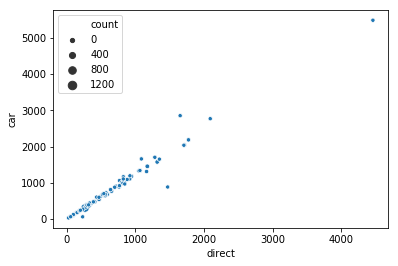

In [14]:
sns.scatterplot(x='direct', y='car', size='count', data=crook)

In [19]:
res1 = stats.siegelslopes(crook['car'], crook['direct'])
res1

(1.2381117602818152, -1.737580003270267)

In [23]:
res2 = stats.theilslopes(crook['car'], crook['direct'], 0.90)
res2

(1.2349523906804416,
 -5.2392289157743335,
 1.2177128860829995,
 1.2553971811374136)

In [24]:
res3 = stats.linregress(crook['direct'], crook['car'])
res3

LinregressResult(slope=1.2436894229514046, intercept=-3.1998439019467924, rvalue=0.9814827889315498, pvalue=2.639451484349886e-56, stderr=0.027842318489030245)